Dataset loaded successfully:
   CustomerID  Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
0       50001      1     4.0         Mobile Phone         3              6.0   
1       50002      1     NaN                Phone         1              8.0   
2       50003      1     NaN                Phone         1             30.0   
3       50004      1     0.0                Phone         3             15.0   
4       50005      1     0.0                Phone         1             12.0   

  PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
0           Debit Card  Female             3.0                         3   
1                  UPI    Male             3.0                         4   
2           Debit Card    Male             2.0                         4   
3           Debit Card    Male             2.0                         4   
4                   CC    Male             NaN                         3   

     PreferedOrderCat  Satisfacti

/Users/xinglingao/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/xinglingao/.pyenv/versions/3.12.8/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


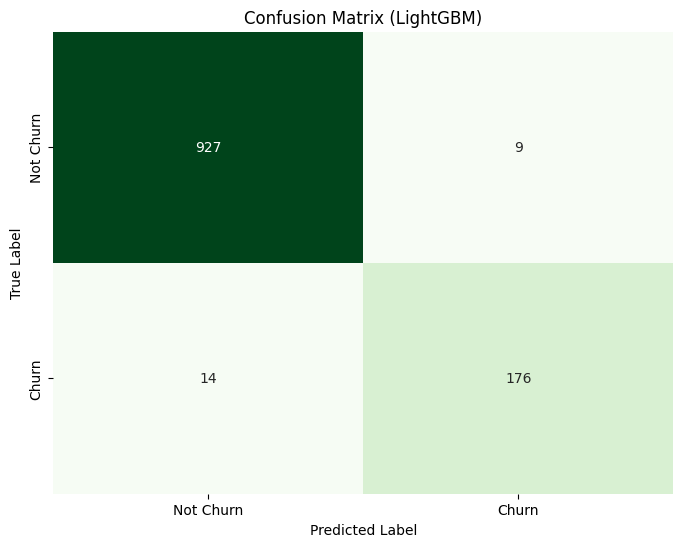


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       936
           1       0.95      0.93      0.94       190

    accuracy                           0.98      1126
   macro avg       0.97      0.96      0.96      1126
weighted avg       0.98      0.98      0.98      1126


Feature Importance (LightGBM - Gini Importance):
                                  Feature  Importance
12                         CashbackAmount         387
2                         WarehouseToHome         339
0                                  Tenure         297
8             OrderAmountHikeFromlastYear         280
6                         NumberOfAddress         218
5                       SatisfactionScore         204
11                      DaySinceLastOrder         196
4                NumberOfDeviceRegistered         120
7                                Complain         119
1                                CityTier         108
10   

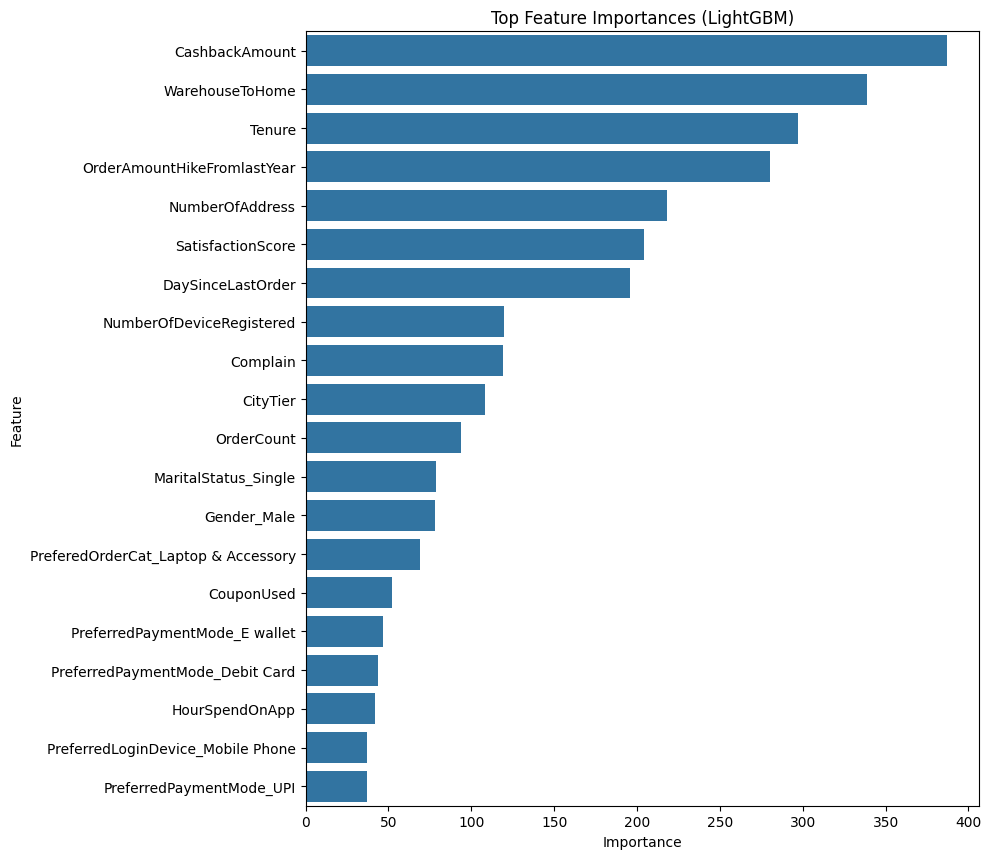

In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb # Import LightGBM
from sklearn.preprocessing import StandardScaler, OneHotEncoder # StandardScaler is optional for LightGBM but good practice in a pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Cell 2: Load the dataset
# Make sure to replace 'ECommerce_Churn_Data.csv' with the actual path/name of your dataset file if it's different.
try:
    df = pd.read_csv('ECommerce_Churn_Data.csv')
except FileNotFoundError:
    print("Error: The dataset file 'ECommerce_Churn_Data.csv' was not found.")
    print("Please download the dataset from https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction?resource=download")
    print("and place it in the correct directory or update the file path.")
    # Exit or raise error if file not found, to prevent further cells from running with an undefined df
    df = pd.DataFrame() # Create an empty DataFrame to avoid NameError if user runs all cells

if not df.empty:
    print("Dataset loaded successfully:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
    print("\nDataset Description:")
    print(df.describe())

# Cell 3: Initial Data Exploration & Preprocessing (if dataset loaded)
if not df.empty:
    # Display column names to identify the target variable and features
    print("\nColumn Names:")
    print(df.columns)

    # Assuming 'Churn' is the target variable. Verify this based on your dataset.
    # If the target column has a different name, update 'Churn' to the correct name.
    target_column = 'Churn'

    if target_column not in df.columns:
        print(f"\nError: Target column '{target_column}' not found in the dataset.")
        print("Please verify the target column name. Common names could be 'Exited', 'Target', etc.")
    else:
        print(f"\nTarget variable: '{target_column}'")
        print(df[target_column].value_counts(normalize=True))

        # Drop CustomerID if it exists, as it's an identifier and not useful for modeling
        if 'CustomerID' in df.columns:
            df = df.drop('CustomerID', axis=1)
            print("\nDropped 'CustomerID' column.")

        # Handle missing values (example: fill with mode for categorical and median for numerical)
        print("\nMissing values before handling:")
        print(df.isnull().sum())

        # Impute missing values
        # For categorical features, fill with mode
        for column in df.select_dtypes(include=['object']).columns:
            df[column] = df[column].fillna(df[column].mode()[0])
        # For numerical features, fill with median (excluding the target column if it's numerical)
        for column in df.select_dtypes(include=[np.number]).columns:
            if column != target_column: # Don't impute the target variable
                 df[column] = df[column].fillna(df[column].median())

        print("\nMissing values after handling:")
        print(df.isnull().sum())

        # Identify categorical and numerical features
        # Ensure target_column is not in features list
        features = [col for col in df.columns if col != target_column]
        categorical_features = df[features].select_dtypes(include=['object']).columns.tolist()
        numerical_features = df[features].select_dtypes(include=[np.number]).columns.tolist()

        print("\nCategorical Features:", categorical_features)
        print("Numerical Features:", numerical_features)

# Cell 4: Define Preprocessing Steps (if dataset loaded and processed)
if not df.empty and target_column in df.columns:
    # Create preprocessing pipelines for numerical and categorical features
    # StandardScaler is not strictly necessary for LightGBM but doesn't hurt and is good practice if comparing models
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

    # Create a preprocessor object using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough'
    )

    # Define features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\nShape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)

# Cell 5: Create and Train the LightGBM Model (if X_train, y_train exist)
if 'X_train' in locals() and 'y_train' in locals(): # Check if variables from previous cell exist
    # Create the LightGBM pipeline
    # You can tune LightGBM parameters for better performance
    lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', lgb.LGBMClassifier(random_state=42, verbosity=-1))]) # verbosity=-1 to suppress training output

    # Train the model
    print("\nTraining the LightGBM model...")
    lgbm_pipeline.fit(X_train, y_train)
    print("Model training complete.")

# Cell 6: Make Predictions and Evaluate the Model (if model is trained)
if 'lgbm_pipeline' in locals() and 'X_test' in locals(): # Check if model and test data exist
    # Make predictions
    y_pred = lgbm_pipeline.predict(X_test)
    y_pred_proba = lgbm_pipeline.predict_proba(X_test)[:, 1] # Probabilities for ROC AUC

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print("\nModel Evaluation (LightGBM):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    # Plotting Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, # Changed cmap for variety
                xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (LightGBM)')
    plt.show()

    print("\nClassification Report:")
    print(class_report)

# Cell 7: Feature Importance (from LightGBM) (if model is trained)
if 'lgbm_pipeline' in locals():
    try:
        # Get feature names after one-hot encoding from the preprocessor
        ohe_feature_names = lgbm_pipeline.named_steps['preprocessor'] \
                                           .named_transformers_['cat'] \
                                           .get_feature_names_out(categorical_features)
        
        all_feature_names = numerical_features + list(ohe_feature_names)

        # Get feature importances from the LightGBM model
        importances = lgbm_pipeline.named_steps['classifier'].feature_importances_

        # Create a DataFrame for feature importance
        feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        print("\nFeature Importance (LightGBM - Gini Importance):")
        print(feature_importance_df)

        # Plot feature importance
        plt.figure(figsize=(10, max(6, len(feature_importance_df['Feature']) * 0.3))) # Adjust height for many features
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20)) # Plot top 20 or all if less
        plt.title('Top Feature Importances (LightGBM)')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"\nCould not display feature importance: {e}")
        print("This might happen if the pipeline structure is different or steps are named differently.")